<center><h2>Tweets Sentiment analysis</h2></center>

<p>For real time tweets sentiment analysis, we need to train a model to help us predict whether tweets are in support of palestine or israel.</p>
<p>Our model will only be able to predict tweets as either supporting of israel or palestine, the model is unable to detect neutral tweets.</p>
<p>We scrapped the data from twitter using selenium.</p>

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, TextVectorization ,Embedding ,GlobalAveragePooling1D ,Dropout ,SpatialDropout1D, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
import re

pd.options.display.max_colwidth = 300
pass

2024-05-26 15:33:37.585677: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 15:33:37.600538: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-26 15:33:37.789565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 15:33:41.812179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv("data.csv",on_bad_lines='skip')
data.head()

,post,usertag,time_date,label,__key__,__error__,__has_error__
0,NaN,NaN,NaN,NaN,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""startingdoc\"""",\n ""kind"": ""posts"",\n ""name"": ""startingdoc"",\n ""id"": null\n }\n}",[],False
1,https://foxnews.com/politics/doj-torched-prosecutors-announce-sam-bankman-fried-face-second-trial…\nThe Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrae...,@Big0range31,2023-12-30 22:55:29,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5SltHdL2FYtDuVweFRXg\"""",\n ""kind"": ""posts"",\n ""name"": ""5SltHdL2FYtDuVweFRXg"",\n ""id"": null\n }\n}",[],False
2,#IStandWithIsrael “thousands at event calling for the country's resettlement of Gaza - NBC News,@LorraineMayLevy,2024-01-29 13:45:32,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5EGsMYmUyHTQeVd27d2c\"""",\n ""kind"": ""posts"",\n ""name"": ""5EGsMYmUyHTQeVd27d2c"",\n ""id"": null\n }\n}",[],False
3,"#istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. \n\nStand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.",@SapphosShahuda,2023-11-29 00:21:06,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5EdJPNUV8Mw4xprgaOCu\"""",\n ""kind"": ""posts"",\n ""name"": ""5EdJPNUV8Mw4xprgaOCu"",\n ""id"": null\n }\n}",[],False
4,"The images of Hamas' brutality are gruesome — reminiscent of the worst of Al-Qaeda, ISIS and the Taliban.\n\nUrge America's leaders to #StandWithIsrael as it defeats this terrorist threat:",@Deborah83556516,2024-01-26 02:35:05,I,"{\n ""__key__"": {\n ""namespace"": """",\n ""app"": ""s~liquid-anchor-419214"",\n ""path"": ""\""posts\"", \""5H9s7aG3b8v8wunxXV3B\"""",\n ""kind"": ""posts"",\n ""name"": ""5H9s7aG3b8v8wunxXV3B"",\n ""id"": null\n }\n}",[],False


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13163 entries, 0 to 13162
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   post           13162 non-null  object
 1   usertag        13162 non-null  object
 2   time_date      13162 non-null  object
 3   label          13162 non-null  object
 4   __key__        13163 non-null  object
 5   __error__      13163 non-null  object
 6   __has_error__  13163 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 630.0+ KB


<p>the first row is the only row with missing values, let's remove it.</p>

In [4]:
data = data.tail(len(data) - 1)

In [5]:
data.columns = ["text","usertag","date","label","__key__","__err __","__has_err __"]
data = data.astype(str)
data["target"] = data["label"].apply(lambda x: 0 if x == "P" else 1)

<p>No error  in the dataset exporting the file from firebase.</p>

In [6]:
data["__has_err __"].unique()

array(['False'], dtype=object)

<p>we will drop \_\_key\_\_ , \_\_err\_\_ and \_\_has\_\_err\_\_ columns.  </p>

In [7]:
data.drop(["__key__","__err __","__has_err __"],axis=1,inplace=True)

In [8]:
data.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 11951 entries, 1 to 13162
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     11951 non-null  object
 1   usertag  11951 non-null  object
 2   date     11951 non-null  object
 3   label    11951 non-null  object
 4   target   11951 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 560.2+ KB


<center><h2>Text processing</h2></center>

<p>For data labeling, we labeled tweets containing pro palestinian tags as in support of palestine (P)  and tweets containing pro israeli tags we labeled them as in support of israel (I).</p>
<ul>
<li>
Pro Palestine tags : #freepalestine
#supportpalestine
#standwithpalestine
#istandwithpalestine
#westandwithpalestine</li>
<li>
Pro Israel tags :  #freeisrael
#supportisrael
#standwithisrael
#istandwithisrael
#westandwithisrael</li>
</ul>
<p>Out of fear that these tags will bias the model too much, we will duplicate the already existing data and remove them.</p>

In [9]:
search_tags = ["#freepalestine","#supportpalestine","#standwithpalestine","#istandwithpalestine","#westandwithpalestine",
               "#freeisrael","#supportisrael","#standwithisrael","#istandwithisrael","#westandwithisrael"]
data2 = data.copy()
data2["text"] = data["text"].apply(lambda x: ' '.join(word for word in x.split() if word.lower() not in search_tags))

In [10]:
data["text"].head(5)

1    https://foxnews.com/politics/doj-torched-prosecutors-announce-sam-bankman-fried-face-second-trial…\nThe Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrae...
2                                                                                                                                                                                                                #IStandWithIsrael “thousands at event calling for the country's resettlement of Gaza - NBC News
3                                                                                         #istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. \n\nStand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.
4                                                                                    

word cloud for data with search tags, as feared the tags appear as the most frequent words, there isn't much variety.

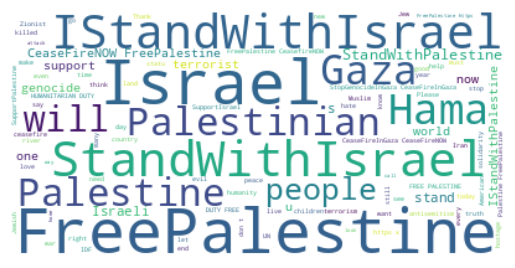

In [11]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

word cloud for data without search tags, we notice a lot more variety in the words.



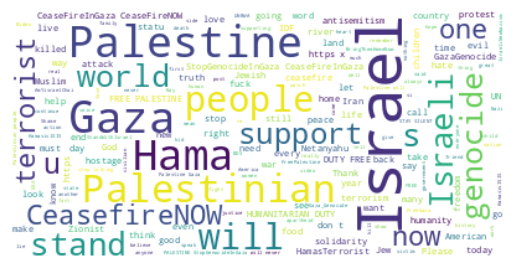

In [12]:
text = " ".join(review for  review in data2["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

I will merge the two datasets into one

In [13]:
data = pd.concat([data,data2])

here is the new word cloud , hopefully this will stop the model from relying too much on the labeling tags so it can be more reliable for predicting tweets that do not contain them.

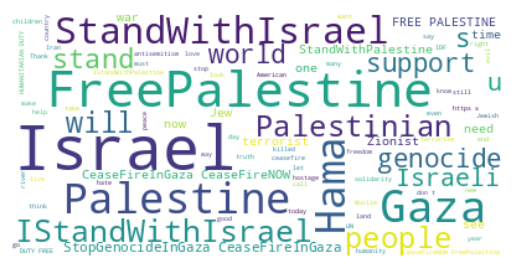

In [14]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Removing URLs, Mentions, Emojis

In [15]:
import preprocessor  as p
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.RESERVED,p.OPT.EMOJI,p.OPT.SMILEY,p.OPT.NUMBER)
data["text"] = data["text"].apply(lambda x : p.clean(x))

In [16]:
data["text"]

1                                    The Department of (In)Justice doing its job protecting the #NaziDemocrats by keeping their treasonous crimes covered up. #NaziScums #ResistingDemocratFascism #DemocratsTheNewNazis #IStandWithIsrael #SupportIsrael
2                                                                                                                                                          #IStandWithIsrael thousands at event calling for the country's resettlement of Gaza - NBC News
3                                      #istandwithisrael and not #istandwithjews means you stand for this : Israel is a militarised ethno state. Stand with the Jewish people, not the barbarians responsible for this, the IDF *is* The state of Israel.
4                                                                 The images of Hamas' brutality are gruesome reminiscent of the worst of Al-Qaeda, ISIS and the Taliban. Urge America's leaders to #StandWithIsrael as it defeats this terrorist threat:


#### Removing punctuation

In [17]:
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
data['text'] = data['text'].apply(lambda x: re.sub(f'[{re.escape(punctuation)}]', '' , str(x)))

#### Camel Case
<p>I noticed a norme of words being combined in a camel case format, where each word starts with a capital letter (EX: #PalestineWillBeFree), we will attempt to seperate these words.</p>

In [19]:
def split_camel_case(word):
    # Regular expression to match camel case patterns, including acronyms
    split_words = re.sub('([a-z0-9])([A-Z])', r'\1 \2', word)
    split_words = re.sub('([A-Z])([A-Z][a-z])', r'\1 \2', split_words)
    return " ".join(split_words.split())

data["text"] = data["text"].apply(split_camel_case)

#### Expanding contractions

In [20]:
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not"}
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
data['text']=data['text'].apply(lambda x:expand_contractions(str(x)))

#### Lower case

In [21]:
data["text"] = data["text"].str.lower()

#### Stop words

In [22]:
from wordcloud import STOPWORDS
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in STOPWORDS]))

#### Lemmatization and stemming

In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import PorterStemmer
 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return "n"

lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def lemmatize_stem_words(text):
    tokens = text.split(" ")
    tagged_tokens = nltk.pos_tag(tokens)
    return " ".join([ps.stem(lemmatizer.lemmatize(word,penn_to_wn(pos))) for word,pos in tagged_tokens])
data["text"] = data["text"].apply(lambda text: lemmatize_stem_words(text))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ayoub/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ayoub/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
data["text"]

1        depart justic job protect nazi democrat keep treason crime cover nazi scum resist democrat fascism democrat new nazi stand israel support israel
2                                                                                          stand israel thousand event call countri resettl gaza nbc news
3                            istandwithisrael istandwithjew mean stand israel militaris ethno state stand jewish peopl barbarian respons idf state israel
4                                      imag hama brutal gruesom reminisc bad al qaeda isi taliban urg america leader stand israel defeat terrorist threat
5                                                                                    well worth read excel histor perspect bring present day stand israel
                                                                               ...                                                                       
13158                                                                       

#### handling data imbalance

<p>There is a bias in the data, we need to make sure there are as many posts in support of palestine as there are in support of israel.</p>

<Axes: xlabel='label', ylabel='count'>

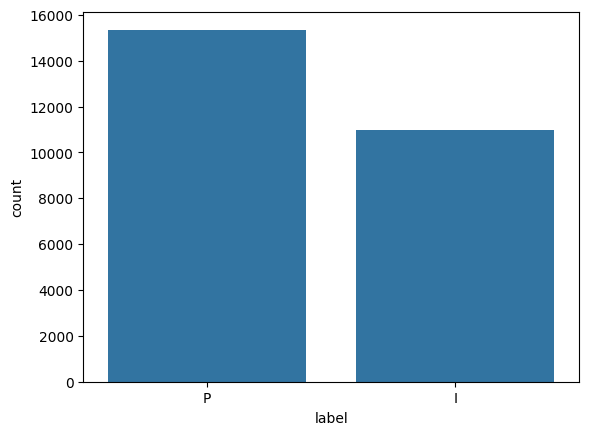

In [25]:
sns.barplot(data["label"].value_counts())

<Axes: xlabel='label', ylabel='count'>

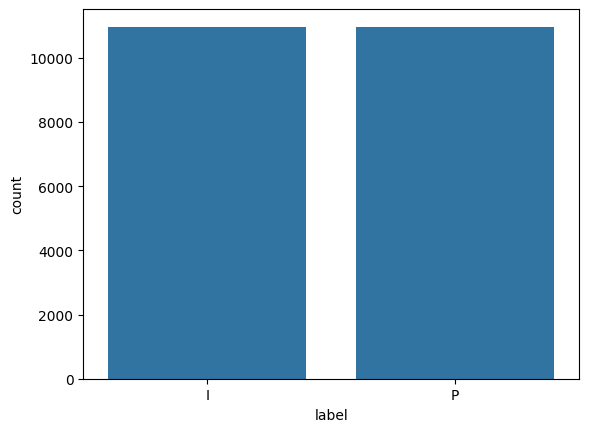

In [26]:
g = data.groupby("label")
data_balanced = g.head(min(data["label"].value_counts()))
sns.barplot(data_balanced["label"].value_counts())

#### Final Dataset

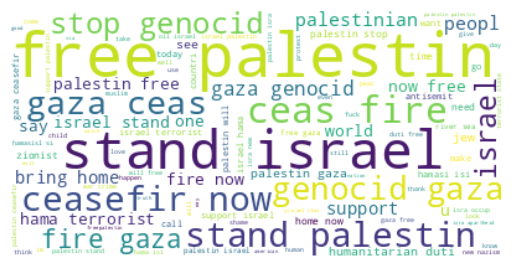

In [27]:
text = " ".join(review for  review in data["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

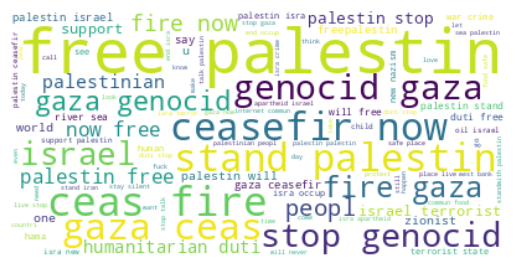

In [28]:
text = " ".join(review for review in data.loc[data["label"] == "P"]["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

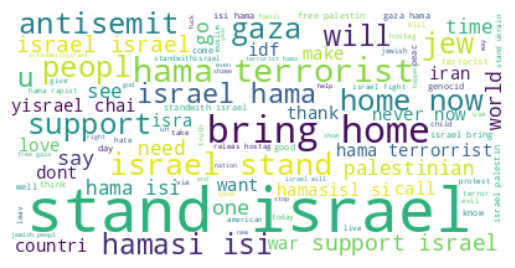

In [29]:
text = " ".join(review for review in data.loc[data["label"] == "I"]["text"])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color ="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
data["text"]

1        depart justic job protect nazi democrat keep treason crime cover nazi scum resist democrat fascism democrat new nazi stand israel support israel
2                                                                                          stand israel thousand event call countri resettl gaza nbc news
3                            istandwithisrael istandwithjew mean stand israel militaris ethno state stand jewish peopl barbarian respons idf state israel
4                                      imag hama brutal gruesom reminisc bad al qaeda isi taliban urg america leader stand israel defeat terrorist threat
5                                                                                    well worth read excel histor perspect bring present day stand israel
                                                                               ...                                                                       
13158                                                                       

<center><h2>Model training</h2></center>

#### Train test Split

In [31]:
x_train, x_test, y_train, y_test = train_test_split(data_balanced["text"],data_balanced["target"], test_size=0.2,random_state=42)
x_train = pd.Series.to_numpy(x_train)
x_test = pd.Series.to_numpy(x_test)
y_train = pd.Series.to_numpy(y_train)
y_test = pd.Series.to_numpy(y_test)

#### Tokenization

In [32]:
MAX_SEQUENCE_LENGTH = 280
VOCAB_SIZE = 10000
int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

In [33]:
int_vectorize_layer.adapt(x_train)

<p>Let's save the tokenizer to disk.</p>

In [62]:
import pickle

pickle.dump({'config': int_vectorize_layer.get_config(),
             'weights': int_vectorize_layer.get_weights()}
            , open("model/vectorizer.pkl", "wb"))

#### Dense Model

In [34]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24
MAX_SEQUENCE_LENGTH = 280
model = Sequential()
model.add(int_vectorize_layer)
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = MAX_SEQUENCE_LENGTH))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
num_epochs = 15
history = model.fit(x_train,
                     y_train,
                     epochs=num_epochs,
                     verbose=2)

Epoch 1/15
549/549 - 10s - 19ms/step - accuracy: 0.5449 - loss: 0.6860
Epoch 2/15
549/549 - 4s - 8ms/step - accuracy: 0.7822 - loss: 0.4934
Epoch 3/15
549/549 - 4s - 7ms/step - accuracy: 0.8621 - loss: 0.3284
Epoch 4/15
549/549 - 4s - 7ms/step - accuracy: 0.8853 - loss: 0.2764
Epoch 5/15
549/549 - 5s - 9ms/step - accuracy: 0.8914 - loss: 0.2607
Epoch 6/15
549/549 - 4s - 8ms/step - accuracy: 0.8950 - loss: 0.2602
Epoch 7/15
549/549 - 5s - 10ms/step - accuracy: 0.8956 - loss: 0.2540
Epoch 8/15
549/549 - 5s - 8ms/step - accuracy: 0.8966 - loss: 0.2522
Epoch 9/15
549/549 - 5s - 9ms/step - accuracy: 0.9007 - loss: 0.2446
Epoch 10/15
549/549 - 5s - 8ms/step - accuracy: 0.9057 - loss: 0.2364
Epoch 11/15
549/549 - 4s - 8ms/step - accuracy: 0.9057 - loss: 0.2301
Epoch 12/15
549/549 - 6s - 10ms/step - accuracy: 0.9102 - loss: 0.2253
Epoch 13/15
549/549 - 5s - 9ms/step - accuracy: 0.9076 - loss: 0.2286
Epoch 14/15
549/549 - 4s - 8ms/step - accuracy: 0.9055 - loss: 0.2317
Epoch 15/15
549/549 - 4s 

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 280)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 280, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,301 (98.84 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,868 (65.89 KB)

138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9069 - loss: 0.2185
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


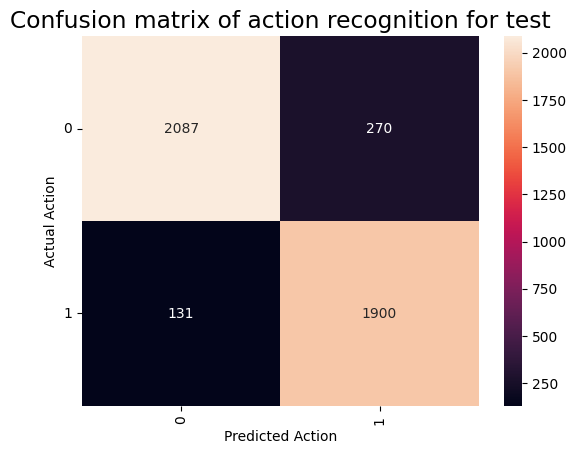

In [37]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
model.evaluate(x_test,y_test)
binary_predictions = (model.predict(x_test) >= 0.5).astype(int)
plot_confusion_matrix(binary_predictions,y_test,[0,1],"test")

In [38]:
print(classification_report(binary_predictions, y_test))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2357
           1       0.88      0.94      0.90      2031

    accuracy                           0.91      4388
   macro avg       0.91      0.91      0.91      4388
weighted avg       0.91      0.91      0.91      4388



<p>we test the model with our own input data and it fails to recognize the last two elements reliably.</p>

In [39]:
from preprocess import preprocess

text = ["I love israel", "I love palestine", "I hate israel israel palestine" , "I hate palestine israel palestine"] 
text = pd.Series.to_numpy(pd.Series([ preprocess(sequence) for sequence in text]))
(model.predict(text) >= 0.5).astype(int)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ayoub/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ayoub/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[1],
       [0],
       [1],
       [0]])

#### LSTM

In [143]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24
n_lstm = 128
drop_lstm = 0.2
MAX_SEQUENCE_LENGTH = 280
model1 = Sequential()
model1.add(int_vectorize_layer)
model1.add(Embedding(vocab_size, embedding_dim))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(tf.keras.layers.Bidirectional(LSTM(units=32)))
model1.add(Dropout(drop_lstm))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

<p>LSTM reaches higher accuracy faster than the dense model.</p>

In [144]:
num_epochs = 5
history = model1.fit(x_train,
                     y_train,
                     epochs=num_epochs,
                     verbose=2)

Epoch 1/5
549/549 - 63s - 114ms/step - accuracy: 0.8717 - loss: 0.2925
Epoch 2/5
549/549 - 59s - 108ms/step - accuracy: 0.9243 - loss: 0.1970
Epoch 3/5
549/549 - 59s - 107ms/step - accuracy: 0.9271 - loss: 0.1810
Epoch 4/5
549/549 - 64s - 116ms/step - accuracy: 0.9307 - loss: 0.1715
Epoch 5/5
549/549 - 59s - 108ms/step - accuracy: 0.9350 - loss: 0.1600


In [108]:
model1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 280)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_22 (Embedding)        │ (None, 280, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_20            │ (None, 280, 16)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 64)             │        12,544 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,701 (459.77 KB)

 Trainable params: 39,233 (153.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 78,468 (306.52 KB)

138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step


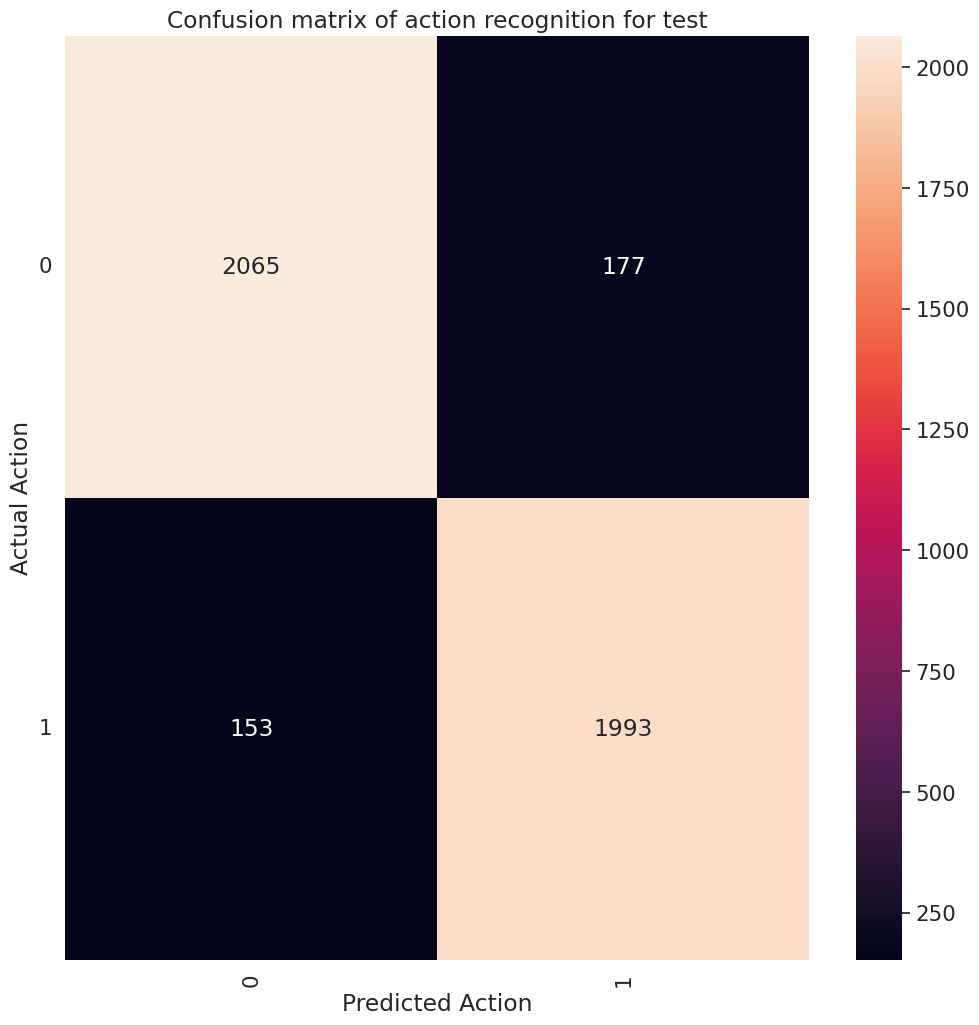

In [109]:
binary_predictions = (model1.predict(x_test) >= 0.5).astype(int)
plot_confusion_matrix(binary_predictions,y_test,[0,1],"test")

In [110]:
print(classification_report(binary_predictions, y_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2242
           1       0.92      0.93      0.92      2146

    accuracy                           0.92      4388
   macro avg       0.92      0.92      0.92      4388
weighted avg       0.92      0.92      0.92      4388



LSTM also fails this test.

In [111]:
from preprocess import preprocess

text = ["I love israel", "I love palestine", "I hate israel israel palestine" , "I hate palestine israel palestine"] 
text = pd.Series.to_numpy(pd.Series([ preprocess(sequence) for sequence in text]))
(model1.predict(text) >= 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[1],
       [0],
       [1],
       [0]])

#### Saving LSTM model in a file
<p>This is the model we will use for the spark streaming application.</p>

In [140]:
model1.save("model.keras")

In [141]:
loaded_model1 = tf.keras.models.load_model("model.keras")

ValueError: A total of 1 objects could not be loaded. Example error message for object <LSTMCell name=lstm_cell, built=True>:

Layer 'lstm_cell' expected 3 variables, but received 0 variables during loading. Expected: ['kernel', 'recurrent_kernel', 'bias']

List of objects that could not be loaded:
[<LSTMCell name=lstm_cell, built=True>]

In [75]:
from tensorflow.keras import layers, Model

def remove_spatial_dropout(model):
    new_input = layers.Input(shape=model.input_shape[1:])
    x = new_input
    
    for layer in model.layers:
        if isinstance(layer, layers.SpatialDropout1D):
            continue
        else:
            x = layer(x)

    new_model = Model(inputs=new_input, outputs=x)
    return new_model

model_without_spatial_dropout = remove_spatial_dropout(model1)
model_without_spatial_dropout.save_weights("model/model.weights.h5")

<p>let's test loading and using the model</p>

In [87]:
from tensorflow.keras import layers, Model, Input

def get_vectorizer():
    from_disk = pickle.load(open("model/vectorizer.pkl", "rb"))
    print(from_disk["config"])
    new_v = TextVectorization.from_config(from_disk['config'])
    #Keras bug need to adapt in order to use
    # new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    new_v.set_weights(from_disk['weights'])
    return new_v


def build_model():
    inputs = Input(shape=(1,), dtype=tf.string)
    x = get_vectorizer()(inputs)
    # Embedding layer
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=MAX_SEQUENCE_LENGTH)(x)
    # SpatialDropout1D layer
    x = layers.SpatialDropout1D(drop_lstm)(x)
    # Bidirectional LSTM layer
    x = layers.Bidirectional(layers.LSTM(units=32))(x)
    # Dropout layer
    x = layers.Dropout(drop_lstm)(x)
    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

loaded_model = build_model()
loaded_model.load_weights("model/model.weights.h5")

{'name': 'text_vectorization', 'trainable': True, 'dtype': 'float32', 'max_tokens': 10000, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int', 'output_sequence_length': 280, 'pad_to_max_tokens': False, 'sparse': False, 'ragged': False, 'vocabulary': None, 'idf_weights': None, 'encoding': 'utf-8', 'vocabulary_size': 10000}


/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [88]:
loaded_model.summary()

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 280)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_18 (Embedding)        │ (None, 280, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_16            │ (None, 280, 16)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 64)             │        12,544 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,233 (153.25 KB)

 Trainable params: 39,233 (153.25 KB)

 Non-trainable params: 0 (0.00 B)

<p>The model gives the same results.</p>

In [89]:
from preprocess import preprocess

text = ["I love israel", "I love palestine", "I hate israel israel palestine" , "I hate palestine israel palestine"] 
text = pd.Series.to_numpy(pd.Series([ preprocess(sequence) for sequence in text]))
loaded_model.predict(text)

2024-05-26 16:45:27.722895: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at lookup_table_op.cc:929 : FAILED_PRECONDITION: Table not initialized.
2024-05-26 16:45:27.723005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: FAILED_PRECONDITION: Table not initialized.
	 [[{{node functional_41_1/text_vectorization_1/None_Lookup/LookupTableFindV2}}]]


FailedPreconditionError: Graph execution error:

Detected at node functional_41_1/text_vectorization_1/None_Lookup/LookupTableFindV2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_33717/854415898.py", line 5, in <module>

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 519, in predict

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 217, in one_step_on_data_distributed

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 206, in one_step_on_data

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 98, in predict_step

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/models/functional.py", line 199, in call

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/ops/function.py", line 151, in _run_through_graph

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/models/functional.py", line 583, in call

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/layer.py", line 826, in __call__

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/preprocessing/text_vectorization.py", line 580, in call

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/preprocessing/string_lookup.py", line 391, in call

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/preprocessing/index_lookup.py", line 716, in call

  File "/home/ayoub/Desktop/projects/SPARK-STREAMING-PFA/Model/my-env/lib/python3.10/site-packages/keras/src/layers/preprocessing/index_lookup.py", line 754, in _lookup_dense

Table not initialized.
	 [[{{node functional_41_1/text_vectorization_1/None_Lookup/LookupTableFindV2}}]] [Op:__inference_one_step_on_data_distributed_44053]